# COMP7220/8220 Major Project.

## Load the dataset from kaggle

Mount the Google Drive files

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Now upload the kaggle.json file

In [2]:
from google.colab import files

files.upload() #this will prompt you to upload the kaggle.json

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ducdannguyen","key":"52ec4b728580211536f0bd34b53f7a2b"}'}

Make sure kaggle.json file is present

In [111]:
!ls -lha kaggle.json

ls: kaggle.json: No such file or directory


Install kaggle API client

In [110]:
!pip install -q kaggle


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


kaggle API client expects the file to be in ~/.kaggle so move it there

In [5]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

We need to set permissions

In [6]:
!chmod 600 /root/.kaggle/kaggle.json

Check your directory before downloading the datasets

In [7]:
!pwd

/content


Download the coarse dataset

In [8]:
!kaggle competitions download -c living-thing-classification-coarse

100% 5.40G/5.40G [03:29<00:00, 40.1MB/s]
100% 5.40G/5.40G [03:29<00:00, 27.7MB/s]


In [9]:
!unzip -q living-thing-classification-coarse.zip 

## Using Code Stub to load the data

In [4]:
import json
import numpy as np
import pandas as pd
import tensorflow as tf
from pathlib import Path
import matplotlib.pyplot as plt

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

%matplotlib inline


Version:  2.12.0
Eager mode:  True
GPU is available


In [5]:
batch_size = 64
img_size = 224
fine_grain = False
num_classes = 50 if fine_grain else 8

root = Path('public')


Some potentially useful functions for reading data from files.

In [6]:
def load_target_names(path='public/info.json'):
    with open(path) as f:
        info = json.load(f)
    return info['fine'], info['coarse']


def load_image(file_path, image_size=112):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, [image_size, image_size])
    return img


def create_dataset_tf(split, fine_grained, batch_size=32, image_size=112):
    df = pd.read_csv(root / f"{split}.csv")
    file_paths = df.filename.map(lambda fn: str(root / split / fn))
    labels = df.fine if fine_grained else df.coarse

    dataset = tf.data.Dataset.from_tensor_slices((file_paths, labels))
    dataset = dataset.map(lambda x, y: (
        load_image(x, image_size=image_size), y))
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset


def create_dataset_sklearn(split, fine_grained, image_size=48, percent=0.1):
    dataset = create_dataset_tf(
        split=split, fine_grained=fine_grained, batch_size=1000, image_size=image_size)
    dataset = dataset.map(lambda x, y: (tf.image.rgb_to_grayscale(x), y))
    X = None
    Y = None
    n_batches = int(len(dataset) * percent)
    for x, y in dataset.take(n_batches):
        x, y = x.numpy(), y.numpy()
        x = x.reshape(x.shape[0], -1)
        X = x if X is None else np.vstack([X, x])
        Y = y if Y is None else np.hstack([Y, y])

    return X, Y


In [7]:
fine_names, coarse_names = load_target_names()
print(coarse_names)


['Aves', 'Reptilia', 'Mammalia', 'Arachnida', 'Magnoliopsida', 'Insecta', 'Liliopsida', 'Pinopsida']


In [8]:
print(fine_names)


['Scolopacidae', 'Laridae', 'Accipitridae', 'Anatidae', 'Corvidae', 'Icteridae', 'Picidae', 'Colubridae', 'Sciuridae', 'Rosaceae', 'Cyperaceae', 'Brassicaceae', 'Sphingidae', 'Orchidaceae', 'Apidae', 'Papilionidae', 'Orobanchaceae', 'Liliaceae', 'Apocynaceae', 'Poaceae', 'Araneidae', 'Pinaceae', 'Asparagaceae', 'Acrididae', 'Hesperiidae', 'Rubiaceae', 'Onagraceae', 'Libellulidae', 'Fagaceae', 'Cactaceae', 'Lycaenidae', 'Coenagrionidae', 'Boraginaceae', 'Ranunculaceae', 'Polygonaceae', 'Pieridae', 'Caryophyllaceae', 'Lamiaceae', 'Noctuidae', 'Apiaceae', 'Malvaceae', 'Geometridae', 'Plantaginaceae', 'Euphorbiaceae', 'Crambidae', 'Parulidae', 'Erebidae', 'Ericaceae', 'Passerellidae', 'Tyrannidae']


Creating datatsets for sklearn (along with showing some images, so you can see what they're like).

In [123]:
X, Y = create_dataset_sklearn('train', fine_grained=fine_grain)


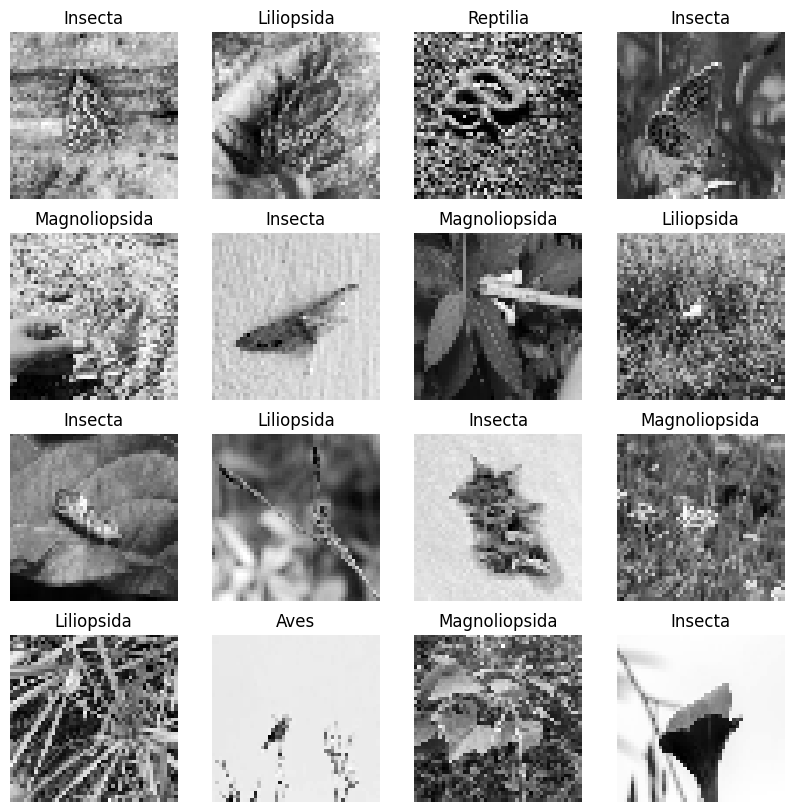

In [ ]:
plt.figure(figsize=(10, 10))

for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(X[i].reshape(48, 48), cmap='gray')
    if fine_grain:
        plt.title(fine_names[Y[i]])
    else:
        plt.title(coarse_names[Y[i]])
    plt.axis("off")
plt.show()


Creating datasets for TensorFlow.

In [13]:
train_ds = create_dataset_tf(
    'train', fine_grained=fine_grain, batch_size=batch_size, image_size=img_size)
val_ds = create_dataset_tf(
    'val', fine_grained=fine_grain, batch_size=batch_size,  image_size=img_size)
test_ds = create_dataset_tf(
    'test', fine_grained=fine_grain, batch_size=batch_size,  image_size=img_size)


Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



# Explore the data set

## Coarse-grained

### Training set

We can look at the first 16 instances from the training set.

In [15]:
import seaborn as sns

# Read the train.csv file into a DataFrame
df = pd.read_csv(root / "train.csv")

# Map the coarse labels to their corresponding names using a dictionary
df['coarse_name'] = df['coarse'].map(dict(zip(list(range(8)), coarse_names)))

# Map the fine labels to their corresponding names using a dictionary
df['fine_name'] = df['fine'].map(dict(zip(list(range(50)), fine_names)))

# Display the first few rows of the DataFrame
df.head(16)


filename  coarse  fine    coarse_name   
0   658b2f15f08dc6b8264b4913b52eb337d7a50692.jpg       5    41        Insecta  \
1   cf7221725164ac5bf8e432decf769611c3ba2f4d.jpg       6    19     Liliopsida   
2   ac0b7d9399a53bc200419253976f64230109bfae.jpg       1     7       Reptilia   
3   b5b968eb2fb0bcca175c115c103f5a33ea8830ba.jpg       5    30        Insecta   
4   a09e9a5ce49ebbf7e774c13eb5a9fc97b152d609.jpg       4    42  Magnoliopsida   
5   92e9a925275d9d96c48db418eb55cbdaafb72867.jpg       5    41        Insecta   
6   0f57f06790fb1b223901d79d6c9624bb36a2e2b8.jpg       4    37  Magnoliopsida   
7   c91c52f8eb3ed89092061d8db24ec131d171755d.jpg       6    10     Liliopsida   
8   c89e48bb476f1beaab7e6a7da6fb380be5dbfd37.jpg       5    46        Insecta   
9   9e1f8b381a9a39b8a653baa6dc12636f673df901.jpg       6    10     Liliopsida   
10  e1301019cf5e4a787a18ac54a481b862a8bb7261.jpg       5    38        Insecta   
11  2896ef1bceffae9f0b044c9efe5e4c3ba226811e.jpg       4    39  Magnoliopsida   
12  9f6d74b0976899e6cc08ca3504cbd5e336498a88.jpg       6    10     Liliopsida   
13  4e59be872129c0078a719998a1aaf29b496f7776.jpg       0     5           Aves   
14  0a5d7ddebacceb98e1d881410a9463adbdf0bbd1.jpg       4    43  Magnoliopsida   
15  0f19d6a6c6ad5cde7df028d01021a65451812ff5.jpg       5    35        Insecta   

         fine_name  
0      Geometridae  
1          Poaceae  
2       Colubridae  
3       Lycaenidae  
4   Plantaginaceae  
5      Geometridae  
6        Lamiaceae  
7       Cyperaceae  
8         Erebidae  
9       Cyperaceae  
10       Noctuidae  
11        Apiaceae  
12      Cyperaceae  
13       Icteridae  
14   Euphorbiaceae  
15        Pieridae

With the code from Code Stub, we can look at the first 16 images from the training set:

2023-05-29 00:16:06.024140: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


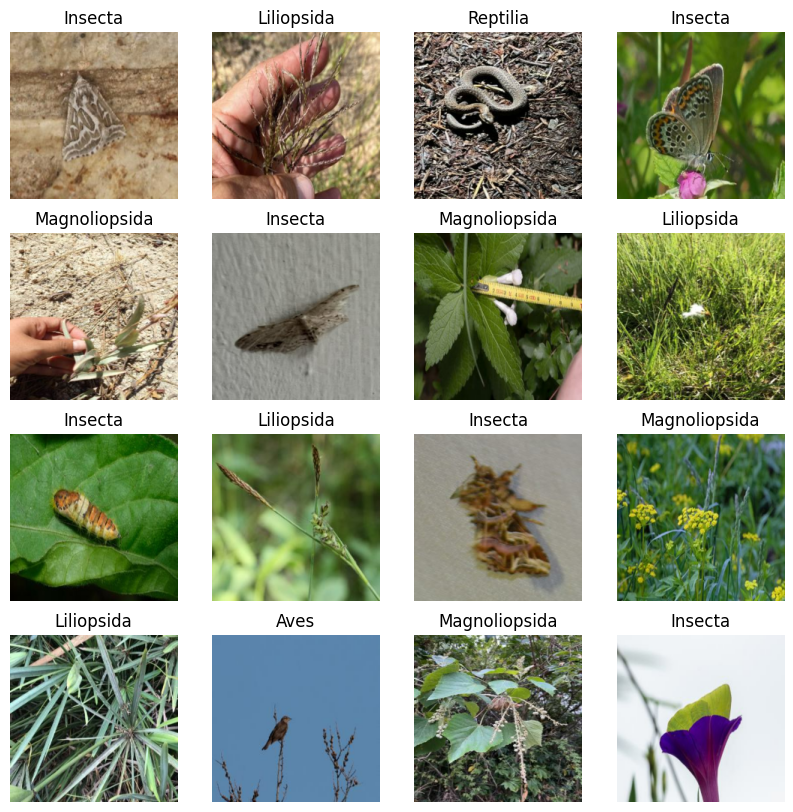

In [14]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):

    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy())
        if fine_grain:
            plt.title(fine_names[labels[i]])
        else:
            plt.title(coarse_names[labels[i]])
        plt.axis("off")
plt.show()

The plot below show the count of each class in the training set.

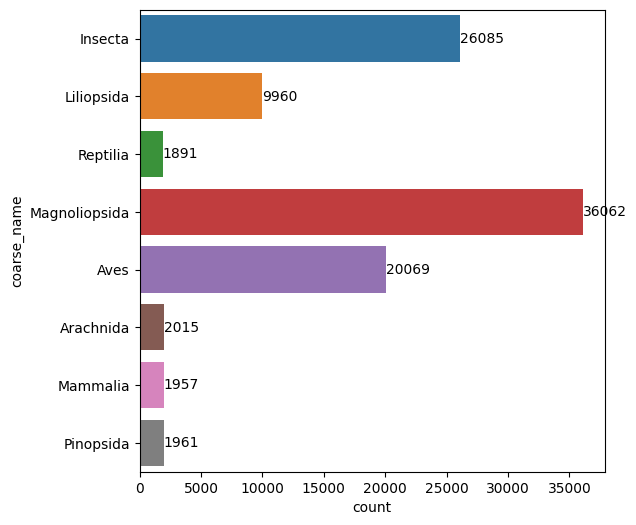

In [16]:
# Set the figure size
plt.figure(figsize=(6, 6))

# Create a countplot using seaborn library, specifying the DataFrame and the column to count ('coarse_name')
ax = sns.countplot(data=df, y='coarse_name')

# Add labels to the bars indicating the count of each category
ax.bar_label(ax.containers[0])

# Display the plot
plt.show()


The class distribution in the training set is imbalanced, with varying numbers of samples for each coarse name. The majority class is Magnoliopsida with the highest number of samples, followed by Insecta and Aves. On the other hand, Arachnida, Pinopsida, Mammalia, and Reptilia have relatively fewer samples compared to the majority classes.

### Validation set

With the same approach as above, we will take a look at the validation set

In [18]:
val_df = pd.read_csv(root / "val.csv")
val_df['coarse_name'] = df['coarse'].map(dict(zip(list(range(8)), coarse_names)))
val_df['fine_name'] = df['fine'].map(dict(zip(list(range(50)), fine_names)))
val_df.head()

filename  coarse  fine    coarse_name   
0  4b8ce4a2d0a13de41940a350bc20a4ee6fe56f80.jpg       4    39        Insecta  \
1  c0260202167eab86fb176346afce166d4738ece1.jpg       4    34     Liliopsida   
2  4cf01a97732947c2313575449cdd3782b2ceb5e7.jpg       7    21       Reptilia   
3  9b478b50b49f3844b1cf1f3fea5d46b92bc0695c.jpg       4    29        Insecta   
4  f82c79a511c8da0eb51cffd41846e35b5d4aee7c.jpg       5    23  Magnoliopsida   

        fine_name  
0     Geometridae  
1         Poaceae  
2      Colubridae  
3      Lycaenidae  
4  Plantaginaceae

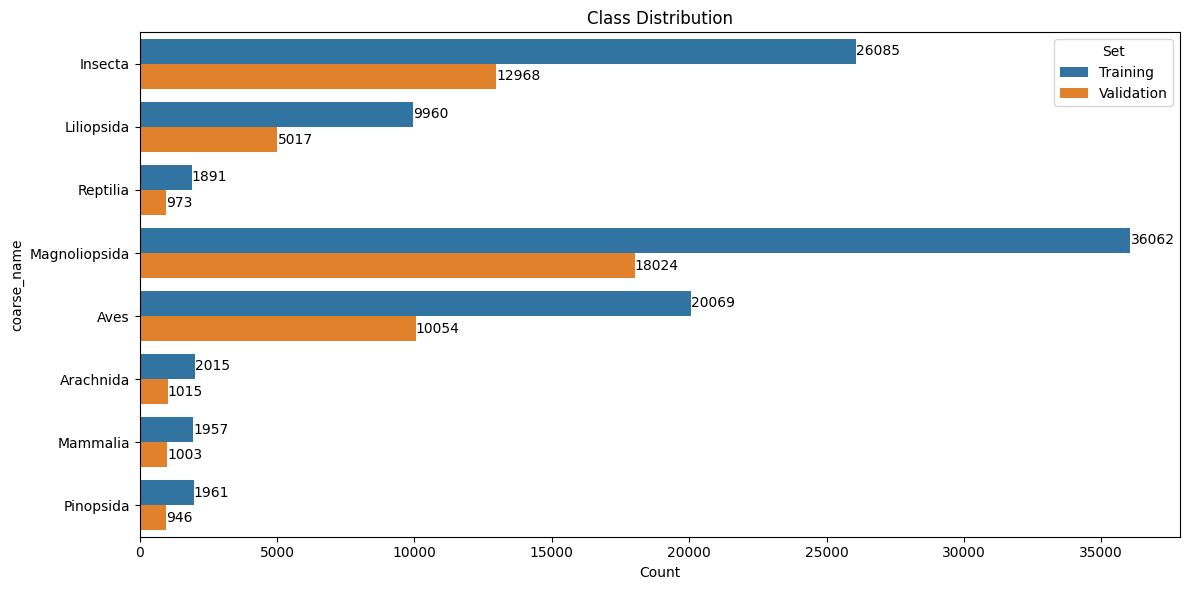

In [35]:
plt.figure(figsize=(12, 6))

# Add a 'Set' column to the dataframes to differentiate between training and validation sets
df['Set'] = 'Training'
val_df['Set'] = 'Validation'

# Combine the training and validation dataframes
combined_df = pd.concat([df, val_df])

# Plot the class distribution
ax = sns.countplot(data=combined_df, y='coarse_name', hue='Set')
for label in ax.containers:
    ax.bar_label(label)
plt.title('Class Distribution')
plt.xlabel('Count')
plt.legend(title='Set')

plt.tight_layout()
plt.show()


The distribution of class labels in the validation set follows a similar trend as the training set, indicating that the validation set is representative of the overall dataset.

## Fine-grained

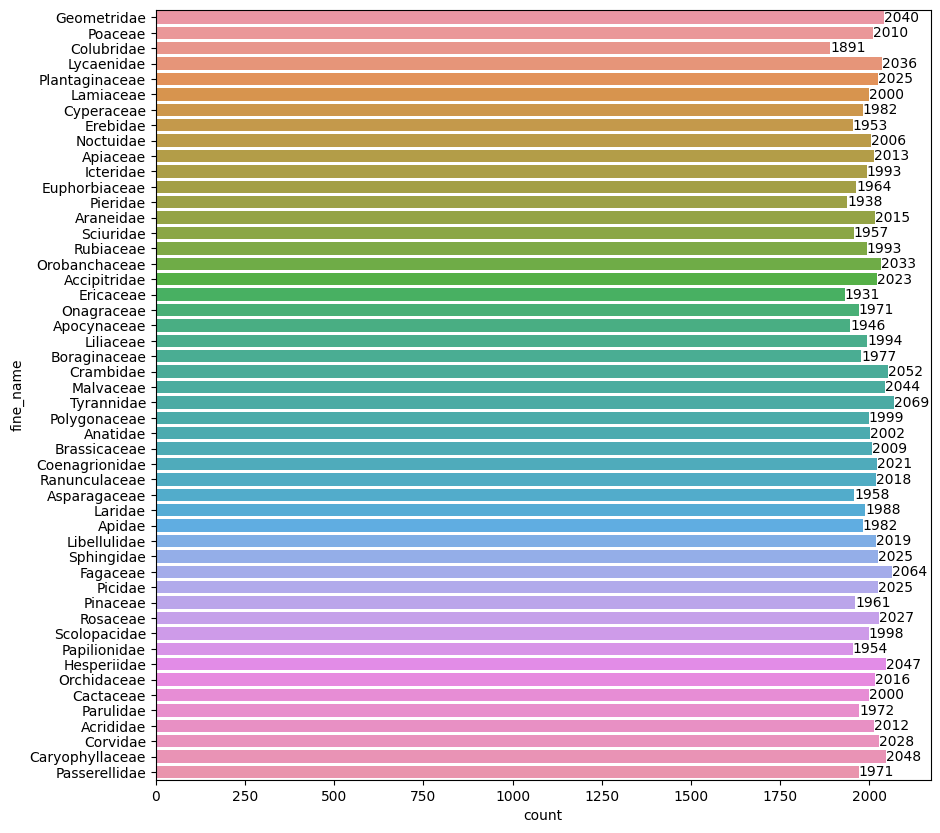

In [ ]:
figure(figsize=(10, 10))
ax = sns.countplot(data=df, y='fine_name')
ax.bar_label(ax.containers[0])
plt.show()


In [ ]:
val_df = pd.read_csv(root / "val.csv")
val_df['coarse_name'] = df['coarse'].map(dict(zip(list(range(8)), coarse_names)))
val_df['fine_name'] = df['fine'].map(dict(zip(list(range(50)), fine_names)))
val_df.head()


filename  coarse  fine    coarse_name   
0  4b8ce4a2d0a13de41940a350bc20a4ee6fe56f80.jpg       4    39        Insecta  \
1  c0260202167eab86fb176346afce166d4738ece1.jpg       4    34     Liliopsida   
2  4cf01a97732947c2313575449cdd3782b2ceb5e7.jpg       7    21       Reptilia   
3  9b478b50b49f3844b1cf1f3fea5d46b92bc0695c.jpg       4    29        Insecta   
4  f82c79a511c8da0eb51cffd41846e35b5d4aee7c.jpg       5    23  Magnoliopsida   

        fine_name  
0     Geometridae  
1         Poaceae  
2      Colubridae  
3      Lycaenidae  
4  Plantaginaceae

#  Conventional Machine Learning Approach

## Training an SVC model

In [ ]:
from sklearn.svm import SVC

# Train a SVC model.
svm_clf = SVC(random_state=42)
svm_clf.fit(X, Y)


SVC(random_state=42)

Load the test data

In [ ]:
# Choose one of these, depending on whether you're building sklearn or keras models
# make sure to use all of the test set for sklearn
X_test, Y_test = create_dataset_sklearn(
    'test', fine_grained=False, percent=1.0)
test_ds = create_dataset_tf(
    'test', fine_grained=fine_grain, batch_size=batch_size)
X_val, Y_val = create_dataset_sklearn('val', fine_grained=False, percent=1.0)


In [ ]:
svm_clf.score(X_val, Y_val)


0.46462

## SGD Classifier

In [ ]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier()
sgd_clf.fit(X=X, y=Y)


SGDClassifier()

In [ ]:
sgd_clf.score(X_val, Y_val)


0.28028

In [ ]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_val, Y_val, cv=3, scoring="accuracy")


array([0.26669467, 0.30143397, 0.31429257])

## Decision Tree Classifier

Training a decision tree instance

In [ ]:
from sklearn.tree import DecisionTreeClassifier
tree_clf = DecisionTreeClassifier()
tree_clf.fit(X, Y)


DecisionTreeClassifier()

Compute the score on validating set

In [ ]:
tree_clf.score(X_val, Y_val)


0.02158

## Voting Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

voting_clf = VotingClassifier(
    estimators=[
        ('lr', LogisticRegression()),
        ('rf', RandomForestClassifier()),
        ('svc', SVC())
    ]
)
voting_clf.fit(X, Y)


/Users/dannguyen/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


VotingClassifier(estimators=[('lr', LogisticRegression()),
                             ('rf', RandomForestClassifier()), ('svc', SVC())])

In [ ]:
voting_clf.score(X_val, Y_val)


0.07768

## AdaBoost Classifier


In [ ]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(), n_estimators=30,
    learning_rate=0.5)
ada_clf.fit(X, Y)


AdaBoostClassifier(base_estimator=DecisionTreeClassifier(), learning_rate=0.5,
                   n_estimators=30)

In [ ]:
ada_clf.score(X_val, Y_val)


0.30984

### Gradient Boosting Regressor


In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
gbrt_best = GradientBoostingClassifier()
gbrt_best.fit(X, Y)


KeyboardInterrupt: 

In [ ]:
gbrt_best.score(X_val, Y_val)


0.07377377403927032

## Stacking Classifier

In [ ]:
from sklearn.ensemble import StackingClassifier

stacking_clf = StackingClassifier(
    estimators=[
        ('lr', LogisticRegression()),
        ('rf', RandomForestClassifier()),
        ('svc', SVC(probability=True))
    ],
    final_estimator=RandomForestClassifier(),
    cv=5  # number of cross-validation folds
)
stacking_clf.fit(X, Y)


In [ ]:
stacking_clf.score(X_val, Y_val)


## Naive Bayes Classifier

In [ ]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(X, Y)


GaussianNB()

In [ ]:
gnb.score(X_val, Y_val)


0.23182

Saving predictions to csv file for Kaggle.

In [ ]:
# This is just making up a vector of predictions.  You should use the predictions of your models.
y_pred = voting_clf.predict(X_test)


In [ ]:
test_csv = pd.read_csv(root / f"test.csv")
test_csv.loc[:, "fine"] = y_pred
test_csv = test_csv.drop(columns=['coarse'])
pred_file = "46864660-conv-vot.csv"  # CHANGE DIRECTORY, FILENAME as appropriate
test_csv.to_csv(pred_file, index=False)


# Deep Learning System

### Artificial Neural Network

In [ ]:
epochs = 10
channel = 3


In [ ]:
tf.random.set_seed(42)
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[img_size, img_size, channel]),
    tf.keras.layers.Dense(300, activation="relu"),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(8, activation="softmax")
])


In [ ]:
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 37632)             0         
                                                                 
 dense_6 (Dense)             (None, 300)               11289900  
                                                                 
 dense_7 (Dense)             (None, 100)               30100     
                                                                 
 dense_8 (Dense)             (None, 8)                 808       
                                                                 
Total params: 11,320,808
Trainable params: 11,320,808
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(loss="sparse_categorical_crossentropy",
                  optimizer="adam",
                  metrics=["accuracy"])


In [ ]:
history = model.fit(train_ds, epochs=10, validation_data=val_ds)


Epoch 1/10
1563/1563 [==============================] - 40s 26ms/step - loss: 1.8214 - accuracy: 0.4134 - val_loss: 1.4605 - val_accuracy: 0.4619
Epoch 2/10
1563/1563 [==============================] - 39s 25ms/step - loss: 1.4301 - accuracy: 0.4737 - val_loss: 1.4010 - val_accuracy: 0.4844
Epoch 3/10
1563/1563 [==============================] - 39s 25ms/step - loss: 1.3832 - accuracy: 0.4918 - val_loss: 1.3788 - val_accuracy: 0.5039
Epoch 4/10
1563/1563 [==============================] - 39s 25ms/step - loss: 1.3498 - accuracy: 0.5049 - val_loss: 1.3660 - val_accuracy: 0.4987
Epoch 5/10
1563/1563 [==============================] - 40s 25ms/step - loss: 1.3315 - accuracy: 0.5119 - val_loss: 1.3422 - val_accuracy: 0.5102
Epoch 6/10
1563/1563 [==============================] - 41s 26ms/step - loss: 1.3156 - accuracy: 0.5203 - val_loss: 1.3268 - val_accuracy: 0.5182
Epoch 7/10
1563/1563 [==============================] - 41s 26ms/step - loss: 1.3026 - accuracy: 0.5240 - val_loss: 1.3141 -

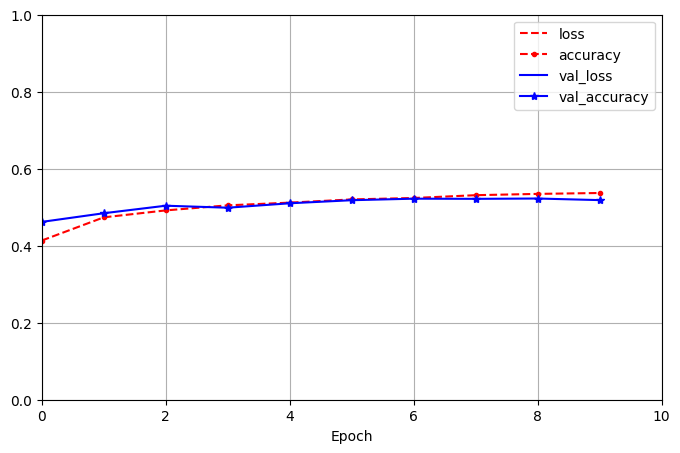

In [ ]:
pd.DataFrame(history.history).plot(
    figsize=(8, 5), xlim=[0, epochs], ylim=[0, 1], grid=True, xlabel="Epoch",
    style=["r--", "r--.", "b-", "b-*"])
plt.show()


In [ ]:
y_proba_test = model.predict(test_ds)
y_proba_test.round(2)


782/782 [==============================] - 9s 11ms/step


array([[0.16, 0.03, 0.02, ..., 0.36, 0.1 , 0.01],
       [0.31, 0.04, 0.04, ..., 0.42, 0.03, 0.02],
       [0.13, 0.01, 0.01, ..., 0.19, 0.13, 0.02],
       ...,
       [0.11, 0.02, 0.02, ..., 0.28, 0.14, 0.01],
       [0.1 , 0.02, 0.01, ..., 0.13, 0.13, 0.08],
       [0.08, 0.  , 0.01, ..., 0.01, 0.08, 0.6 ]], dtype=float32)

In [ ]:
y_pred = y_proba_test.argmax(axis=-1)
y_pred


array([5, 5, 4, ..., 4, 4, 7])

In [ ]:
test_csv = pd.read_csv(root / f"test.csv")
test_csv.loc[:, "coarse"] = y_pred
test_csv = test_csv.drop(columns=['fine'])
pred_file = "46864660-deep-seq.csv"  # CHANGE DIRECTORY, FILENAME as appropriate
test_csv.to_csv(pred_file, index=False)


2/2 [==============================] - 0s 8ms/step


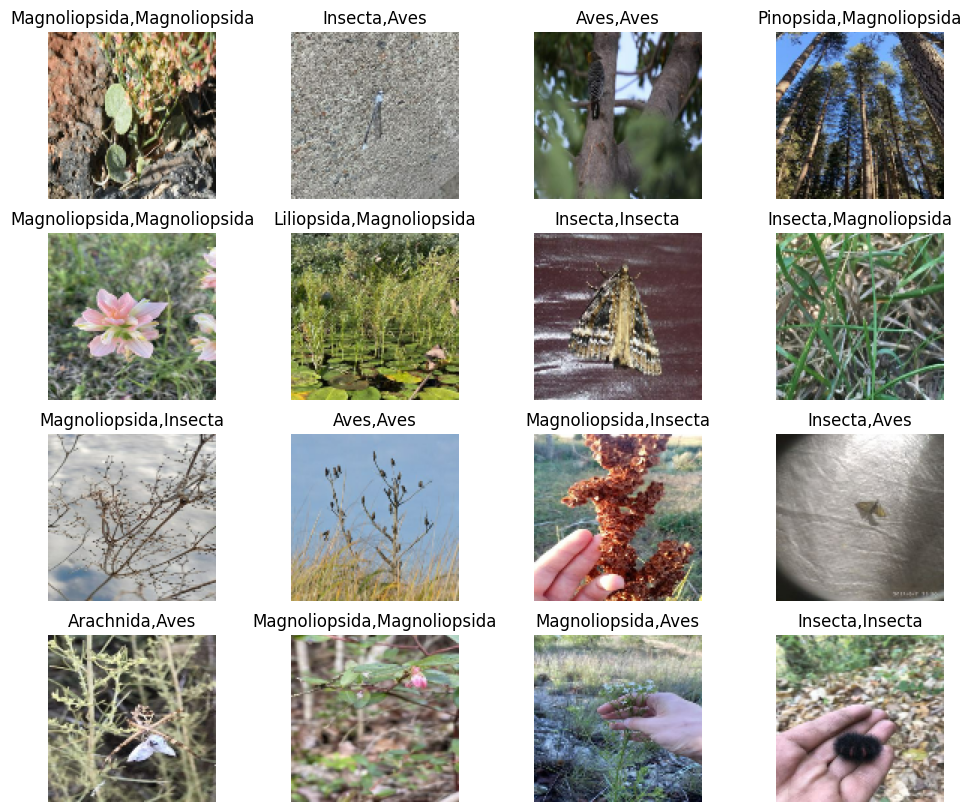

In [ ]:
plt.figure(figsize=(12, 10))
for images, labels in train_ds.take(2):
    preds = model.predict(images).argmax(axis=-1)
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy())
        if fine_grain:
            plt.title(fine_names[labels[i]])
        else:
            plt.title(coarse_names[labels[i]] + ',' + coarse_names[preds[i]])
        plt.axis("off")
plt.show()


In [ ]:
from time import strftime


def get_run_logdir(root_logdir="projects_logs"):
    return Path(root_logdir) / strftime("run_%Y_%m_%d_%H_%M_%S")


run_logdir = get_run_logdir()


In [ ]:
tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir,
                                                profile_batch=(100, 200))
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    patience=3, restore_best_weights=True)

In [ ]:

history = model.fit(train_ds, epochs=20,
                        validation_data=val_ds,
                        callbacks=[tensorboard_cb])


Epoch 1/20


KeyboardInterrupt: ignored

In [ ]:
%load_ext tensorboard
%tensorboard - -logdir = ./projects_logs


In [ ]:
import keras_tuner as kt


def build_model(hp):
    n_hidden = hp.Int("n_hidden", min_value=0, max_value=8, default=2)
    n_neurons = hp.Int("n_neurons", min_value=16, max_value=256)
    learning_rate = hp.Float("learning_rate", min_value=1e-4, max_value=1e-2,
                             sampling="log")
    optimizer = hp.Choice("optimizer", values=["sgd", "adam"])
    if optimizer == "sgd":
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    else:
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten())
    for _ in range(n_hidden):
        model.add(tf.keras.layers.Dense(n_neurons, activation="relu"))
    model.add(tf.keras.layers.Dense(8, activation="softmax"))
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
                  metrics=["accuracy"])
    return model


In [ ]:
class MyClassificationHyperModel(kt.HyperModel):
    def build(self, hp):
        return build_model(hp)

    def fit(self, hp, model, ds, **kwargs):
        return model.fit(ds, **kwargs)


In [ ]:
hyperband_tuner = kt.Hyperband(
    MyClassificationHyperModel(), objective="val_accuracy", seed=42,
    max_epochs=10, factor=3, hyperband_iterations=2,
    overwrite=True, directory="my_coarse", project_name="hyperband")


In [ ]:
# root_logdir = Path(hyperband_tuner.project_dir) / "tensorboard"
# tensorboard_cb = tf.keras.callbacks.TensorBoard(root_logdir)

# hyperband_tuner.search(train_ds, epochs=10,
#                        validation_data=val_ds,
#                        callbacks=[early_stopping_cb, tensorboard_cb])


## Convolutional Neural Network

In [ ]:
from functools import partial

DefaultConv2D = partial(tf.keras.layers.Conv2D, kernel_size=3, padding="same",
                        activation="relu", kernel_initializer="he_normal")
conv_model = tf.keras.Sequential([
    DefaultConv2D(filters=64, kernel_size=7, input_shape=[
                  img_size, img_size, channel]),
    tf.keras.layers.MaxPool2D(),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    tf.keras.layers.MaxPool2D(),
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=128, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=64, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=8, activation="softmax")
])


In [ ]:
conv_model.compile(loss="sparse_categorical_crossentropy",
                   optimizer="adam",
                   metrics=["accuracy"])


In [ ]:
run_logdir = get_run_logdir('conv_model')
tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir,
                                                profile_batch=(100, 200))
history = conv_model.fit(train_ds, epochs=20,
                         validation_data=val_ds,
                         callbacks=[tensorboard_cb, early_stopping_cb])


NameError: ignored

In [ ]:
y_proba_test = conv_model.predict(test_ds)
y_pred = y_proba_test.argmax(axis=-1)
y_pred
test_csv = pd.read_csv(root / f"test.csv")
test_csv.loc[:, "coarse"] = y_pred
test_csv = test_csv.drop(columns=['fine'])
# CHANGE DIRECTORY, FILENAME as appropriate
pred_file = "46864660-deep-conv.csv"
test_csv.to_csv(pred_file, index=False)


782/782 [==============================] - 53s 68ms/step


2/2 [==============================] - 0s 46ms/step


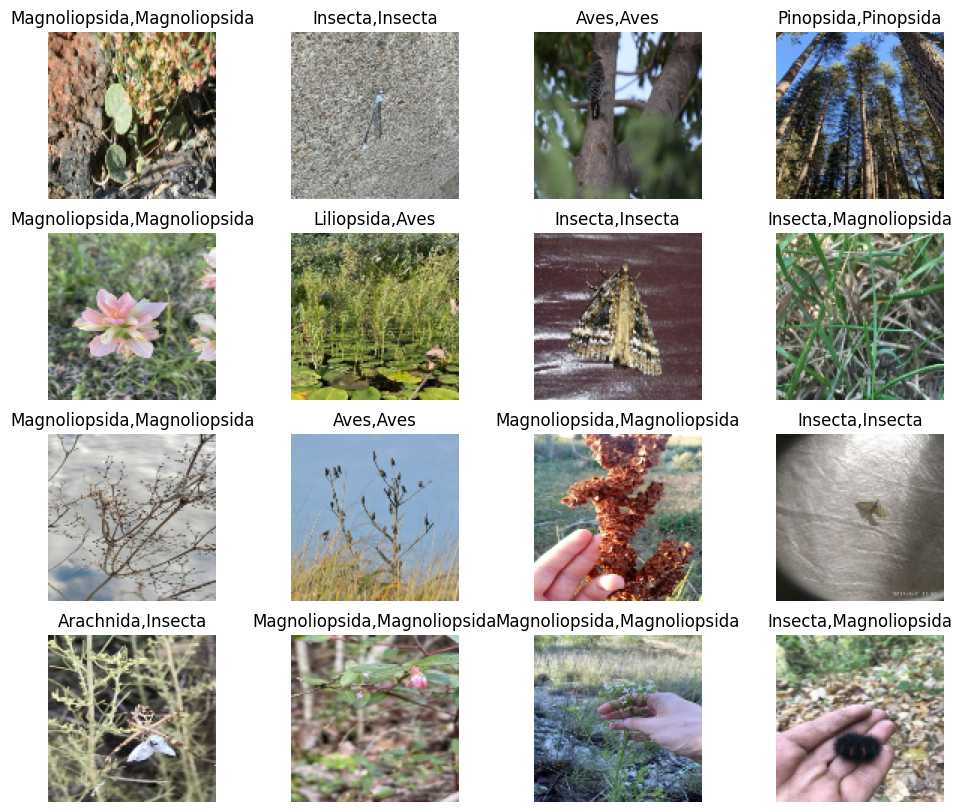

In [ ]:
plt.figure(figsize=(12, 10))
for images, labels in train_ds.take(2):
    preds = conv_model.predict(images).argmax(axis=-1)
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy())
        if fine_grain:
            plt.title(fine_names[labels[i]])
        else:
            plt.title(coarse_names[labels[i]] + ',' + coarse_names[preds[i]])
        plt.axis("off")
plt.show()


## InceptionV3

In [7]:
batch_size = 64
img_size = 224
fine_grain = False
num_classes = 50 if fine_grain else 8

root = Path('dataset/public')


Some potentially useful functions for reading data from files.

Creating datasets for TensorFlow.

In [133]:
train_ds_coarse = create_dataset_tf(
    'train', fine_grained=False, batch_size=batch_size, image_size=img_size)
val_ds_coarse = create_dataset_tf(
    'val', fine_grained=False, batch_size=batch_size,  image_size=img_size)
test_ds_coarse = create_dataset_tf(
    'test', fine_grained=False, batch_size=batch_size,  image_size=img_size)


In [ ]:
train_ds_fine = create_dataset_tf(
    'train', fine_grained=fine_grain, batch_size=batch_size, image_size=img_size)
val_ds_fine = create_dataset_tf(
    'val', fine_grained=fine_grain, batch_size=batch_size,  image_size=img_size)
test_ds_fine = create_dataset_tf(
    'test', fine_grained=fine_grain, batch_size=batch_size,  image_size=img_size)


In [11]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    patience=3, restore_best_weights=True)

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = dict(zip(np.unique(Y), compute_class_weight(class_weight="balanced",
                                                            classes=np.unique(
                                                                Y),
                                                            y=Y)))

In [ ]:
class_weights

{0: 0.6290890790135883,
 1: 6.793478260869565,
 2: 7.142857142857143,
 3: 5.63063063063063,
 4: 0.34473248758963043,
 5: 0.47728140511645667,
 6: 1.2388503468780971,
 7: 7.022471910112359}

In [ ]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip(mode="horizontal_and_vertical"),
    tf.keras.layers.RandomZoom(0.3, 0.3),
    tf.keras.layers.RandomRotation(factor=0.2),
])

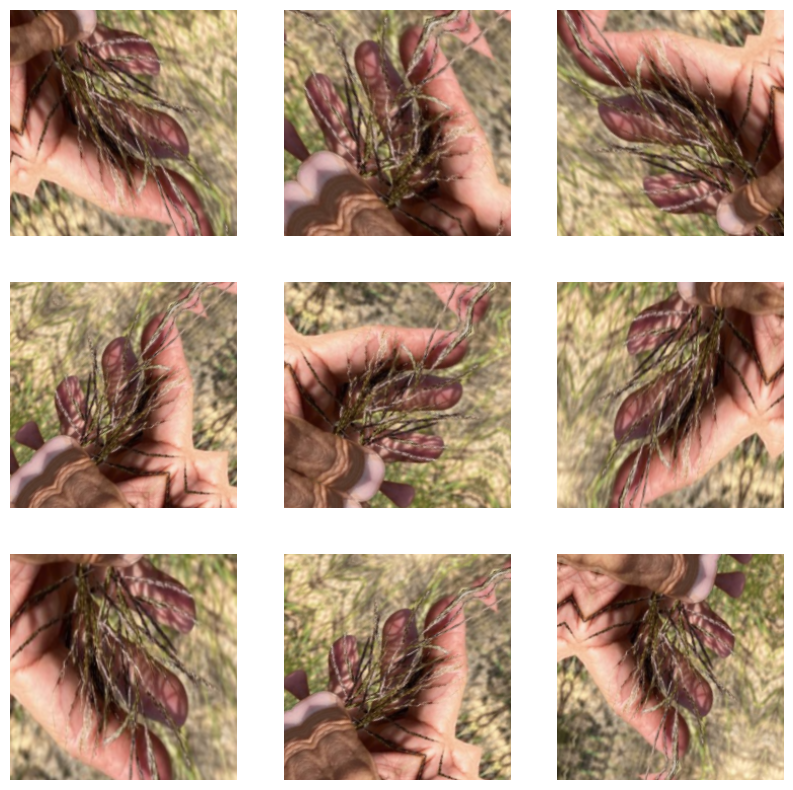

In [ ]:
for image, _ in train_ds_coarse.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[1]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0])
    plt.axis('off')

In [ ]:
# create the base pre-trained model
base_model_coarse = tf.keras.applications.InceptionResNetV2(
    weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3),)

for layer in base_model_coarse.layers:
    layer.trainable = False

inputs = tf.keras.Input(shape=(img_size, img_size, 3))
x = data_augmentation(inputs)  # Apply random data augmentation
x = base_model_coarse(x)

# add a global spatial average pooling layer
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x) 
# and a logistic layer -- let's say we have 200 classes
predictions = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

# create the base pre-trained model
model_coarse = tf.keras.Model(inputs=inputs, outputs=predictions)
model_coarse.summary()


Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_2 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 inception_resnet_v2 (Functi  (None, 5, 5, 1536)       54336736  
 onal)                                                           
                                                                 
 global_average_pooling2d_3   (None, 1536)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_3 (Dropout)         (None, 1536)              0         
                                                                 
 dense_3 (Dense)             (None, 8)                 1229

In [ ]:
# compile the model (should be done *after* setting layers to non-trainable)
model_coarse.compile(loss="sparse_categorical_crossentropy",
                  optimizer="adam",
                  metrics=["accuracy"])


In [ ]:
run_logdir = get_run_logdir('eff_model')
tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir,
                                                profile_batch=(100, 200))

In [ ]:
%load_ext tensorboard
%tensorboard - -logdir = ./eff_model

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


ERROR: Failed to launch TensorBoard (exited with 2).
Contents of stderr:
2023-05-26 20:22:55.147089: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
usage: tensorboard [-h] [--helpfull] [--logdir PATH] [--logdir_spec PATH_SPEC]
                   [--host ADDR] [--bind_all] [--port PORT]
                   [--reuse_port BOOL] [--load_fast {false,auto,true}]
                   [--extra_data_server_flags EXTRA_DATA_SERVER_FLAGS]
                   [--grpc_creds_type {local,ssl,ssl_dev}]
                   [--grpc_data_provider PORT] [--purge_orphaned_data BOOL]
                   [--db URI] [--db_import] [--inspect] [--version_tb]
                   [--tag TAG] [--event_file PATH] [--path_prefix PATH]
                   [--window_title TEXT] [--max_reload_threads COUNT]
                   [--reload_interval SECONDS] [--reload_task TYPE]
                   [--reload_multifile BOOL]
                   [--reload_multifile_inactive_secs SECONDS]

In [ ]:
initial_epochs = 5

In [ ]:
# train the model on the new data for a few epochs
history_coarse = model_coarse.fit(train_ds_coarse, epochs=initial_epochs,
                        validation_data=val_ds_coarse,
                        callbacks=[early_stopping_cb],)

Epoch 1/5
1563/1563 [==============================] - 399s 224ms/step - loss: 0.8150 - accuracy: 0.7202 - val_loss: 0.5909 - val_accuracy: 0.7943
Epoch 2/5
1563/1563 [==============================] - 368s 235ms/step - loss: 0.7580 - accuracy: 0.7356 - val_loss: 0.5883 - val_accuracy: 0.7960
Epoch 3/5
1563/1563 [==============================] - 355s 227ms/step - loss: 0.7514 - accuracy: 0.7385 - val_loss: 0.5777 - val_accuracy: 0.7991
Epoch 4/5
1563/1563 [==============================] - 353s 226ms/step - loss: 0.7464 - accuracy: 0.7400 - val_loss: 0.5797 - val_accuracy: 0.7980
Epoch 5/5
1563/1563 [==============================] - 353s 226ms/step - loss: 0.7451 - accuracy: 0.7420 - val_loss: 0.5819 - val_accuracy: 0.7963


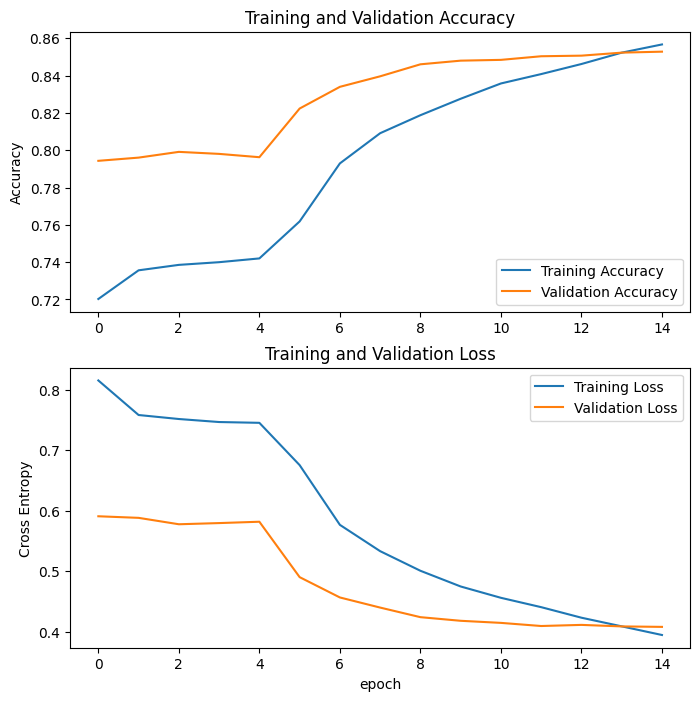

In [ ]:
acc = history_coarse.history['accuracy']
val_acc = history_coarse.history['val_accuracy']

loss = history_coarse.history['loss']
val_loss = history_coarse.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
for i, layer in enumerate(base_model.layers):
    print(i, layer.name)

0 input_3
1 conv2d
2 batch_normalization
3 activation
4 conv2d_1
5 batch_normalization_1
6 activation_1
7 conv2d_2
8 batch_normalization_2
9 activation_2
10 max_pooling2d
11 conv2d_3
12 batch_normalization_3
13 activation_3
14 conv2d_4
15 batch_normalization_4
16 activation_4
17 max_pooling2d_1
18 conv2d_8
19 batch_normalization_8
20 activation_8
21 conv2d_6
22 conv2d_9
23 batch_normalization_6
24 batch_normalization_9
25 activation_6
26 activation_9
27 average_pooling2d
28 conv2d_5
29 conv2d_7
30 conv2d_10
31 conv2d_11
32 batch_normalization_5
33 batch_normalization_7
34 batch_normalization_10
35 batch_normalization_11
36 activation_5
37 activation_7
38 activation_10
39 activation_11
40 mixed_5b
41 conv2d_15
42 batch_normalization_15
43 activation_15
44 conv2d_13
45 conv2d_16
46 batch_normalization_13
47 batch_normalization_16
48 activation_13
49 activation_16
50 conv2d_12
51 conv2d_14
52 conv2d_17
53 batch_normalization_12
54 batch_normalization_14
55 batch_normalization_17
56 activa

In [ ]:
for layer in base_model_coarse.layers:
    layer.trainable = True

In [ ]:
for layer in base_model_coarse.layers[:630]:
    layer.trainable = False
for layer in base_model_coarse.layers[630:]:
    layer.trainable = True
model_coarse.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_2 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 inception_resnet_v2 (Functi  (None, 5, 5, 1536)       54336736  
 onal)                                                           
                                                                 
 global_average_pooling2d_3   (None, 1536)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_3 (Dropout)         (None, 1536)              0         
                                                                 
 dense_3 (Dense)             (None, 8)                 1229

In [ ]:
model_coarse.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),  # Low learning rate
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'],
)

In [ ]:
history_coarse_2 = model_coarse.fit(train_ds_coarse, epochs=10, validation_data=val_ds_coarse, callbacks=[
                        early_stopping_cb])


Epoch 1/10
1563/1563 [==============================] - 427s 254ms/step - loss: 0.6753 - accuracy: 0.7618 - val_loss: 0.4905 - val_accuracy: 0.8224
Epoch 2/10
1563/1563 [==============================] - 394s 252ms/step - loss: 0.5767 - accuracy: 0.7929 - val_loss: 0.4569 - val_accuracy: 0.8340
Epoch 3/10
1563/1563 [==============================] - 375s 240ms/step - loss: 0.5334 - accuracy: 0.8091 - val_loss: 0.4403 - val_accuracy: 0.8396
Epoch 4/10
1563/1563 [==============================] - 368s 235ms/step - loss: 0.5010 - accuracy: 0.8188 - val_loss: 0.4244 - val_accuracy: 0.8461
Epoch 5/10
1563/1563 [==============================] - 401s 256ms/step - loss: 0.4751 - accuracy: 0.8276 - val_loss: 0.4184 - val_accuracy: 0.8480
Epoch 6/10
1563/1563 [==============================] - 399s 255ms/step - loss: 0.4564 - accuracy: 0.8358 - val_loss: 0.4150 - val_accuracy: 0.8485
Epoch 7/10
1563/1563 [==============================] - 367s 235ms/step - loss: 0.4409 - accuracy: 0.8408 - val_

In [ ]:
model_coarse.save("InceptionResNetV2_coarse", save_format="tf")

In [ ]:
!zip -r /content/InceptionResNetV2_coarse.zip /content/InceptionResNetV2_coarse

In [1]:
!cp InceptionResNetV2_coarse.zip gdrive/MyDrive


In [ ]:
acc += history_coarse_2.history['accuracy']
val_acc += history_coarse_2.history['val_accuracy']

loss += history_coarse_2.history['loss']
val_loss += history_coarse_2.history['val_loss']

In [ ]:
print(acc)
print(val_acc)
print(loss)
print(val_loss)

[0.7202200293540955, 0.7355999946594238, 0.7385200262069702, 0.7399600148200989, 0.7419800162315369, 0.7618200182914734, 0.7929400205612183, 0.8091300129890442, 0.8187800049781799, 0.8276100158691406, 0.8358100056648254, 0.8408399820327759, 0.8462399840354919, 0.8523300290107727, 0.8567299842834473]
[0.7943199872970581, 0.7960399985313416, 0.7991200089454651, 0.798039972782135, 0.7962599992752075, 0.8223599791526794, 0.8339999914169312, 0.8396400213241577, 0.8460800051689148, 0.848039984703064, 0.8484600186347961, 0.8503999710083008, 0.8507199883460999, 0.8523399829864502, 0.8528599739074707]
[0.8150334358215332, 0.7579990029335022, 0.7513959407806396, 0.7464184165000916, 0.7451080679893494, 0.6753279566764832, 0.5767467617988586, 0.5333551168441772, 0.500987708568573, 0.47506171464920044, 0.45636963844299316, 0.44093942642211914, 0.4235322177410126, 0.4092853367328644, 0.3950178027153015]
[0.5909244418144226, 0.588307797908783, 0.5777400135993958, 0.5796839594841003, 0.581899583339691

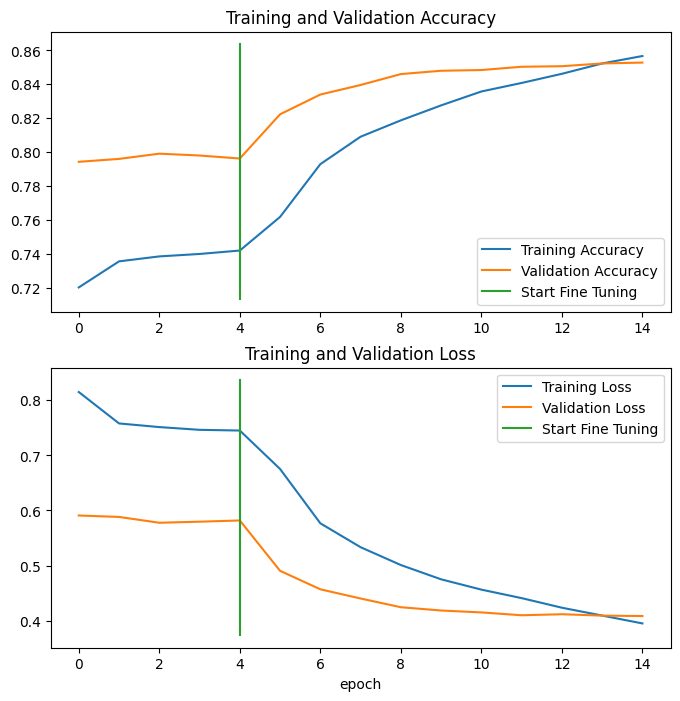

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [13]:
!cp -r gdrive/MyDrive/InceptionV3 .

In [19]:
!unzip -q InceptionResNetV2_coarse.zip

In [130]:
model_coarse = tf.keras.saving.load_model("content/InceptionResNetV2_coarse/")

In [15]:
for layer in model_coarse.layers:
    print(layer)

In [16]:
base_model_coarse = model_coarse.layers[2]

In [17]:
for layer in base_model_coarse.layers[:303]:
    layer.trainable = False
for layer in base_model_coarse.layers:
    layer.trainable = True
model_coarse.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_4 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_3 (Dense)             (None, 8)                 16392     
                                                                 
Total params: 21,819,176
Trainable params: 21,784,744
Non-trainable params: 34,432
____________________________________________

In [128]:
model_coarse.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_4 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_3 (Dense)             (None, 8)                 16392     
                                                                 
Total params: 21,819,176
Trainable params: 21,784,744
Non-trainable params: 34,432
____________________________________________

In [131]:
model.evaluate(val_ds)

782/782 [==============================] - 133s 170ms/step - loss: 0.4614 - accuracy: 0.8533


[0.46138936281204224, 0.8532800078392029]

In [18]:
model_coarse.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),  # Low learning rate
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'],
)

In [19]:
history_coarse_fine = model_coarse.fit(train_ds_coarse, epochs=20, validation_data=val_ds_coarse)

Epoch 1/20
1563/1563 [==============================] - 485s 273ms/step - loss: 0.1670 - accuracy: 0.9417 - val_loss: 0.4598 - val_accuracy: 0.8537
Epoch 2/20
1563/1563 [==============================] - 377s 241ms/step - loss: 0.1503 - accuracy: 0.9473 - val_loss: 0.4663 - val_accuracy: 0.8518
Epoch 3/20
1563/1563 [==============================] - 376s 241ms/step - loss: 0.1306 - accuracy: 0.9543 - val_loss: 0.4834 - val_accuracy: 0.8518
Epoch 4/20
1563/1563 [==============================] - 420s 269ms/step - loss: 0.1170 - accuracy: 0.9596 - val_loss: 0.4706 - val_accuracy: 0.8587
Epoch 5/20
1563/1563 [==============================] - 419s 268ms/step - loss: 0.1045 - accuracy: 0.9644 - val_loss: 0.4929 - val_accuracy: 0.8564
Epoch 6/20
1563/1563 [==============================] - 373s 239ms/step - loss: 0.0915 - accuracy: 0.9694 - val_loss: 0.4969 - val_accuracy: 0.8580
Epoch 7/20
1563/1563 [==============================] - 417s 267ms/step - loss: 0.0822 - accuracy: 0.9724 - val_

In [ ]:
model.save("inc_model", save_format="tf")

KeyboardInterrupt: ignored

In [134]:
y_proba_test = model_coarse.predict(test_ds_coarse)
y_pred = y_proba_test.argmax(axis=-1)
y_pred
test_csv = pd.read_csv(root / f"test.csv")
test_csv.loc[:, "coarse"] = y_pred
test_csv = test_csv.drop(columns=['fine'])
# CHANGE DIRECTORY, FILENAME as appropriate
pred_file = "46864660-deep-coarse.csv"
test_csv.to_csv(pred_file, index=False)


KeyboardInterrupt: 

In [ ]:
# at this point, the top layers are well trained and we can start fine-tuning
# convolutional layers from inception V3. We will freeze the bottom N layers
# and train the remaining top layers.

# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
from tensorflow.keras.optimizers import SGD
for layer in model.layers[:249]:
    layer.trainable = False
for layer in model.layers[249:]:
    layer.trainable = True

# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
                  loss='sparse_categorical_crossentropy')

# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers
history = incv3_model.fit(train_ds, epochs=20,
                          validation_data=val_ds,
                          callbacks=[tensorboard_cb, early_stopping_cb])


Epoch 1/20
1563/1563 [==============================] - 122s 78ms/step - loss: 0.5898 - accuracy: 0.7856 - val_loss: 1.1407 - val_accuracy: 0.6582
Epoch 2/20
1563/1563 [==============================] - 120s 77ms/step - loss: 0.5412 - accuracy: 0.8031 - val_loss: 1.1879 - val_accuracy: 0.6563
Epoch 3/20
1563/1563 [==============================] - 120s 77ms/step - loss: 0.4992 - accuracy: 0.8184 - val_loss: 1.2678 - val_accuracy: 0.6475


## Load the test data

In [ ]:
batch_size = 64
img_size = 224
fine_grain = True
num_classes = 50 if fine_grain else 8

root = Path('dataset/public')


Some potentially useful functions for reading data from files.

In [ ]:
def load_target_names(path='dataset/public/info.json'):
    with open(path) as f:
        info = json.load(f)
    return info['fine'], info['coarse']


def load_image(file_path, image_size=112):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, [image_size, image_size])
    return img


def create_dataset_tf(split, fine_grained, batch_size=32, image_size=112):
    df = pd.read_csv(root / f"{split}.csv")
    file_paths = df.filename.map(lambda fn: str(root / split / fn))
    labels = df.fine if fine_grained else df.coarse

    dataset = tf.data.Dataset.from_tensor_slices((file_paths, labels))
    dataset = dataset.map(lambda x, y: (
        load_image(x, image_size=image_size), y))
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset


def create_dataset_sklearn(split, fine_grained, image_size=48, percent=0.1):
    dataset = create_dataset_tf(
        split=split, fine_grained=fine_grained, batch_size=1000, image_size=image_size)
    dataset = dataset.map(lambda x, y: (tf.image.rgb_to_grayscale(x), y))
    X = None
    Y = None
    n_batches = int(len(dataset) * percent)
    for x, y in dataset.take(n_batches):
        x, y = x.numpy(), y.numpy()
        x = x.reshape(x.shape[0], -1)
        X = x if X is None else np.vstack([X, x])
        Y = y if Y is None else np.hstack([Y, y])

    return X, Y


In [ ]:
fine_names, coarse_names = load_target_names()
print(coarse_names)


['Aves', 'Reptilia', 'Mammalia', 'Arachnida', 'Magnoliopsida', 'Insecta', 'Liliopsida', 'Pinopsida']


In [ ]:
print(fine_names)


['Scolopacidae', 'Laridae', 'Accipitridae', 'Anatidae', 'Corvidae', 'Icteridae', 'Picidae', 'Colubridae', 'Sciuridae', 'Rosaceae', 'Cyperaceae', 'Brassicaceae', 'Sphingidae', 'Orchidaceae', 'Apidae', 'Papilionidae', 'Orobanchaceae', 'Liliaceae', 'Apocynaceae', 'Poaceae', 'Araneidae', 'Pinaceae', 'Asparagaceae', 'Acrididae', 'Hesperiidae', 'Rubiaceae', 'Onagraceae', 'Libellulidae', 'Fagaceae', 'Cactaceae', 'Lycaenidae', 'Coenagrionidae', 'Boraginaceae', 'Ranunculaceae', 'Polygonaceae', 'Pieridae', 'Caryophyllaceae', 'Lamiaceae', 'Noctuidae', 'Apiaceae', 'Malvaceae', 'Geometridae', 'Plantaginaceae', 'Euphorbiaceae', 'Crambidae', 'Parulidae', 'Erebidae', 'Ericaceae', 'Passerellidae', 'Tyrannidae']


Creating datasets for TensorFlow.

In [ ]:
train_ds_coarse = create_dataset_tf(
    'train', fine_grained=False, batch_size=batch_size, image_size=img_size)
val_ds_coarse = create_dataset_tf(
    'val', fine_grained=False, batch_size=batch_size,  image_size=img_size)
test_ds_coarse = create_dataset_tf(
    'test', fine_grained=False, batch_size=batch_size,  image_size=img_size)


In [ ]:
train_ds_fine = create_dataset_tf(
    'train', fine_grained=fine_grain, batch_size=batch_size, image_size=img_size)
val_ds_fine = create_dataset_tf(
    'val', fine_grained=fine_grain, batch_size=batch_size,  image_size=img_size)
test_ds_fine = create_dataset_tf(
    'test', fine_grained=fine_grain, batch_size=batch_size,  image_size=img_size)


In [ ]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    patience=3, restore_best_weights=True)

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = dict(zip(np.unique(Y), compute_class_weight(class_weight="balanced",
                                                            classes=np.unique(
                                                                Y),
                                                            y=Y)))

In [ ]:
class_weights

{0: 0.6290890790135883,
 1: 6.793478260869565,
 2: 7.142857142857143,
 3: 5.63063063063063,
 4: 0.34473248758963043,
 5: 0.47728140511645667,
 6: 1.2388503468780971,
 7: 7.022471910112359}

In [ ]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip(mode="horizontal"),
    tf.keras.layers.RandomZoom(0.5, 0.2),
    tf.keras.layers.RandomRotation(factor=0.1),
])

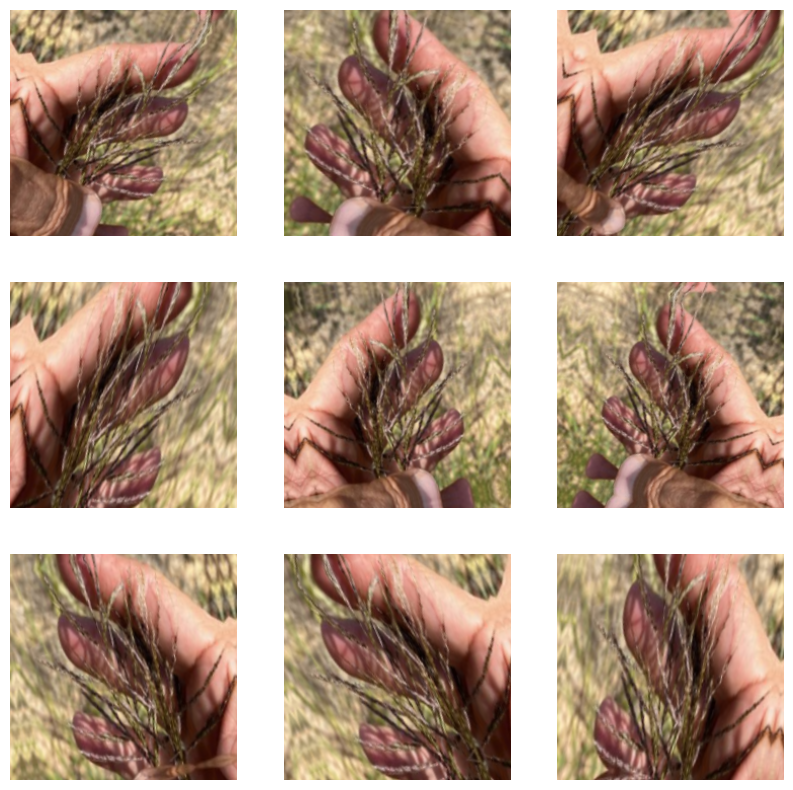

In [ ]:
for image, _ in train_ds_coarse.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[1]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0])
    plt.axis('off')

In [ ]:
# create the base pre-trained model
base_model = tf.keras.applications.inception_v3.InceptionV3(
    weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3),)

for layer in base_model.layers:
    layer.trainable = False

inputs = tf.keras.Input(shape=(img_size, img_size, 3))
x = data_augmentation(inputs)  # Apply random data augmentation
x = base_model(x)

# add a global spatial average pooling layer
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x) 
# and a logistic layer -- let's say we have 200 classes
predictions = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

# create the base pre-trained model
model = tf.keras.Model(inputs=inputs, outputs=predictions)
model.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_1 (Dropout)         (None, 2048)              0         
                                                                 
 dense_1 (Dense)             (None, 50)                102450    
                                                           

In [ ]:
# compile the model (should be done *after* setting layers to non-trainable)
model.compile(loss="sparse_categorical_crossentropy",
                  optimizer="adam",
                  metrics=["accuracy"])


In [ ]:
# train the model on the new data for a few epochs
history = model.fit(train_ds_fine, epochs=3,
                        validation_data=val_ds_fine,
                        callbacks=[early_stopping_cb],)

Epoch 1/3
1563/1563 [==============================] - 343s 211ms/step - loss: 2.5606 - accuracy: 0.3194 - val_loss: 2.1118 - val_accuracy: 0.4138
Epoch 2/3
1563/1563 [==============================] - 254s 162ms/step - loss: 2.3917 - accuracy: 0.3575 - val_loss: 2.0697 - val_accuracy: 0.4259
Epoch 3/3
1562/1563 [============================>.] - ETA: 0s - loss: 2.3574 - accuracy: 0.3671

In [ ]:
for i, layer in enumerate(base_model.layers):
    print(i, layer.name)

0 input_3
1 conv2d_94
2 batch_normalization_94
3 activation_94
4 conv2d_95
5 batch_normalization_95
6 activation_95
7 conv2d_96
8 batch_normalization_96
9 activation_96
10 max_pooling2d_4
11 conv2d_97
12 batch_normalization_97
13 activation_97
14 conv2d_98
15 batch_normalization_98
16 activation_98
17 max_pooling2d_5
18 conv2d_102
19 batch_normalization_102
20 activation_102
21 conv2d_100
22 conv2d_103
23 batch_normalization_100
24 batch_normalization_103
25 activation_100
26 activation_103
27 average_pooling2d_9
28 conv2d_99
29 conv2d_101
30 conv2d_104
31 conv2d_105
32 batch_normalization_99
33 batch_normalization_101
34 batch_normalization_104
35 batch_normalization_105
36 activation_99
37 activation_101
38 activation_104
39 activation_105
40 mixed0
41 conv2d_109
42 batch_normalization_109
43 activation_109
44 conv2d_107
45 conv2d_110
46 batch_normalization_107
47 batch_normalization_110
48 activation_107
49 activation_110
50 average_pooling2d_10
51 conv2d_106
52 conv2d_108
53 conv2d

In [ ]:
for layer in base_model.layers:
    layer.trainable = True

In [ ]:
for layer in base_model.layers[:287]:
    layer.trainable = False
for layer in base_model.layers[287:]:
    layer.trainable = True
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_1 (Dropout)         (None, 2048)              0         
                                                                 
 dense_1 (Dense)             (None, 50)                102450    
                                                           

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),  # Low learning rate
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'],
)

In [ ]:
history = model.fit(train_ds_fine, epochs=5, validation_data=val_ds_fine, callbacks=[
                        early_stopping_cb])


Epoch 1/5
1563/1563 [==============================] - 246s 152ms/step - loss: 2.1839 - accuracy: 0.3990 - val_loss: 1.9471 - val_accuracy: 0.4542
Epoch 2/5
1563/1563 [==============================] - 218s 140ms/step - loss: 2.1102 - accuracy: 0.4124 - val_loss: 1.9121 - val_accuracy: 0.4616
Epoch 3/5
1563/1563 [==============================] - 236s 151ms/step - loss: 2.0754 - accuracy: 0.4185 - val_loss: 1.8898 - val_accuracy: 0.4667
Epoch 4/5
1563/1563 [==============================] - 221s 141ms/step - loss: 2.0479 - accuracy: 0.4254 - val_loss: 1.8723 - val_accuracy: 0.4703
Epoch 5/5
1563/1563 [==============================] - 232s 148ms/step - loss: 2.0317 - accuracy: 0.4298 - val_loss: 1.8580 - val_accuracy: 0.4743


In [ ]:
model.save("InceptionV3_fine", save_format="tf")

In [ ]:
!zip -r /content/InceptionResNetV2.zip /content/InceptionResNetV2

In [ ]:
!cp gdrive/MyDrive/InceptionResNetV2.zip .

In [ ]:
!unzip -q InceptionResNetV2.zip

In [ ]:
!cp InceptionResNetV2.zip gdrive/MyDrive

In [ ]:
model = tf.keras.saving.load_model("content/InceptionResNetV2")

In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 inception_resnet_v2 (Functi  (None, 5, 5, 1536)       54336736  
 onal)                                                           
                                                                 
 global_average_pooling2d_1   (None, 1536)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_1 (Dense)             (None, 8)                 12296     
                                                                 
Total params: 54,349,032
Trainable params: 12,981,960
Non-t

In [ ]:
for layer in model.layers:
    print(layer)
    layer.trainable = True

In [ ]:
model.layers[2] = data_augmentation

In [ ]:
for layer in base_model.layers[:149]:
    layer.trainable = False
for layer in base_model.layers[149:]:
    layer.trainable = True
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_1 (Dropout)         (None, 2048)              0         
                                                                 
 dense_1 (Dense)             (None, 50)                102450    
                                                           

In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_1 (Dropout)         (None, 2048)              0         
                                                                 
 dense_1 (Dense)             (None, 50)                102450    
                                                           

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),  # Low learning rate
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'],
)

In [ ]:
history = model.fit(train_ds_fine, epochs=10, validation_data=val_ds_fine)

Epoch 1/10
1563/1563 [==============================] - 261s 167ms/step - loss: 0.9528 - accuracy: 0.7164 - val_loss: 1.5044 - val_accuracy: 0.5881
Epoch 2/10
1563/1563 [==============================] - 260s 166ms/step - loss: 0.9205 - accuracy: 0.7259 - val_loss: 1.5030 - val_accuracy: 0.5884
Epoch 3/10
1563/1563 [==============================] - 256s 164ms/step - loss: 0.8948 - accuracy: 0.7343 - val_loss: 1.5155 - val_accuracy: 0.5891
Epoch 4/10
1563/1563 [==============================] - 259s 166ms/step - loss: 0.8643 - accuracy: 0.7423 - val_loss: 1.5311 - val_accuracy: 0.5901
Epoch 5/10
1563/1563 [==============================] - 263s 168ms/step - loss: 0.8363 - accuracy: 0.7508 - val_loss: 1.5371 - val_accuracy: 0.5890
Epoch 6/10
1563/1563 [==============================] - 255s 163ms/step - loss: 0.8100 - accuracy: 0.7583 - val_loss: 1.5416 - val_accuracy: 0.5910
Epoch 7/10
1563/1563 [==============================] - 257s 164ms/step - loss: 0.7842 - accuracy: 0.7672 - val_

In [ ]:
model.save("inc_model", save_format="tf")

KeyboardInterrupt: ignored

In [ ]:
y_proba_test = model.predict(test_ds_fine)
y_pred = y_proba_test.argmax(axis=-1)
y_pred
test_csv = pd.read_csv(root / f"test.csv")
test_csv.loc[:, "fine"] = y_pred
test_csv = test_csv.drop(columns=['coarse'])
# CHANGE DIRECTORY, FILENAME as appropriate
pred_file = "46864660-deep-fine.csv"
test_csv.to_csv(pred_file, index=False)


782/782 [==============================] - 149s 133ms/step


In [ ]:
# at this point, the top layers are well trained and we can start fine-tuning
# convolutional layers from inception V3. We will freeze the bottom N layers
# and train the remaining top layers.

# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
from tensorflow.keras.optimizers import SGD
for layer in model.layers[:249]:
    layer.trainable = False
for layer in model.layers[249:]:
    layer.trainable = True

# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
                  loss='sparse_categorical_crossentropy')

# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers
history = incv3_model.fit(train_ds, epochs=20,
                          validation_data=val_ds,
                          callbacks=[tensorboard_cb, early_stopping_cb])


Epoch 1/20
1563/1563 [==============================] - 122s 78ms/step - loss: 0.5898 - accuracy: 0.7856 - val_loss: 1.1407 - val_accuracy: 0.6582
Epoch 2/20
1563/1563 [==============================] - 120s 77ms/step - loss: 0.5412 - accuracy: 0.8031 - val_loss: 1.1879 - val_accuracy: 0.6563
Epoch 3/20
1563/1563 [==============================] - 120s 77ms/step - loss: 0.4992 - accuracy: 0.8184 - val_loss: 1.2678 - val_accuracy: 0.6475
